In [45]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import time
from geopandas import GeoDataFrame
from utils.basefuncs import preProcessDataFrame
from utils.trajectoryClass import Trajectory
from utils.uuid import UUIDCollection
from utils.stopCollection import stopCollection,ExtractAndOrganizeData
from utils.gravityModel import POIgdf,activityMapper,gravityModel
from datetime import datetime,timedelta
import movingpandas as mpd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from ast import literal_eval
from utils.basefuncs import plotTrajectoryWithStops,obtain_daily_trajectory

In [2]:
warnings.filterwarnings("ignore")

In [3]:
configs = {
    'col_missing_vals' : ['gpstime_Hour',
        'gpstime_Minute',
        'gpstime_Second',
        'gpstime_Day',
        'gpstime_Month',
        'gpstime_Year',
        'gpstime'],
    'fill_missing_vals' : [
        'ts_Hour',
       'ts_Minute', 
       'ts_Second', 
       'ts_Day', 
       'ts_Month', 
       'ts_Year', 
       'ts'],
    'UUID_Collection':{
        'unique_identifier_col' : 'uuid',
        'index_col' : 'ts_Index',
        'sort_values_col' : 'ts',
         'lat_col' : 'latitude',
        'long_col' : 'longitude',
        'required_cols' : ['gpsacc','lost'],
        'min_duration' : timedelta(seconds=30*60),
        'max_diameter' : 25,
        'min_points' : 100,
        'query_amount' : 500,
        'plot_map' : False
    },
    'STOP_Collection':{
        'min_distance' : 100,
        'stop_point_num' : 400
    },
    'POIgdf':{
        'id_col':'UUID',
        'poi_type_col_name' : 'POI Type',
        'activity_type_col_name':'Activity Types',
        'poi_point_col_name':'POI Point',
        'stop_point_lat': 'Stop Point Latitude',
        'stop_point_long':'Stop Point Longitude',
    },
    'activityMapper':{
        'file_path' : r"D:\MSc\MSBD 5014\FindingPointsOfInterestFromGPS\helper\POITypes.csv",
    },
    'usePickle':True,
} 

In [ ]:
# import pickle

# with open('poigdf_obj.pickle','wb') as handle:
#     pickle.dump(poigdf_obj,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open('activitymapper_obj.pickle','wb') as handle:
#     pickle.dump(activitymapper_obj,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open('gravitymodel.pickle','wb') as handle:
#     pickle.dump(gravitymodel,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open('stopcollection.pickle','wb') as handle:
#     pickle.dump(stop_collection_obj,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open('uuidcollection.pickle','wb') as handle:
#     pickle.dump(uuid_collection_obj,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
#load pickles
import pickle
with open('poigdf_obj.pickle','rb') as handle:
    poigdf_obj = pickle.load(handle)

with open('activitymapper_obj.pickle','rb') as handle:
    activitymapper_obj = pickle.load(handle)

with open('gravitymodel.pickle','rb') as handle:
    gravitymodel = pickle.load(handle)

with open('stopcollection.pickle','rb') as handle:
    stop_collection_obj = pickle.load(handle)

with open('uuidcollection.pickle','rb') as handle:
    uuid_collection_obj = pickle.load(handle)



In [6]:
possible_pois = poigdf_obj.poi_gdf.copy()

In [14]:
possible_pois

,Stop Point,UUID,POI Point,POI Name,POI Type,Time Spent at Stop Point,Stop Point Latitude,Stop Point Longitude,Activity Types
0,POINT (114.19380 22.34506),111926,POINT (114.193536 22.3451875),TamJai SamGor MiXian,"['restaurant', 'food']",16833.0,22.345057,114.193804,['Food']
1,POINT (114.19380 22.34506),111926,POINT (114.1936614 22.3448671),Maxim's MX,"['restaurant', 'food']",16833.0,22.345057,114.193804,['Food']
2,POINT (114.19380 22.34506),111926,POINT (114.1936343 22.3447961),順鑫腸粉佬,"['restaurant', 'food']",16833.0,22.345057,114.193804,['Food']
3,POINT (114.19380 22.34506),111926,POINT (114.1933114 22.3450458),Chuk Yuen Plaza,['shopping_mall'],16833.0,22.345057,114.193804,['Shopping/Daily Shopping']
4,POINT (114.19380 22.34506),111926,POINT (114.1935384 22.34502090000001),Jade garden restaurant,"['restaurant', 'food']",16833.0,22.345057,114.193804,['Food']
...,...,...,...,...,...,...,...,...,...
3778,POINT (114.14136 22.37093),111566,POINT (114.1408599 22.3704995),Ju Ching Chu Secondary School (Kwai Chung),['school'],2127.0,22.370926,114.141365,['School']
3779,POINT (114.14136 22.37093),111566,POINT (114.1417744 22.3707228),OK便利店,"['convenience_store', 'food']",2127.0,22.370926,114.141365,"['Food', 'Daily Shopping']"
3780,POINT (114.14136 22.37093),111566,POINT (114.1415615 22.3709132),kimura bakery,"['bakery', 'food']",2127.0,22.370926,114.141365,['Food']
3781,POINT (114.14136 22.37093),111566,POINT (114.1416403 22.3709609),On Yam Square,['shopping_mall'],2127.0,22.370926,114.141365,['Shopping/Daily Shopping']


Assigning Latitude and Longitude separately for filtered stops

In [15]:
filtered_stops = stop_collection_obj.filtered_stops.copy()
filtered_stops['latitude'] = filtered_stops.apply(lambda x:x['geometry'].y,axis = 1)
filtered_stops['longitude'] = filtered_stops.apply(lambda x:x['geometry'].x,axis = 1)

Attaching time of stop point into possible POIS

In [26]:
with_time_interval = possible_pois.merge(filtered_stops[['start_time','end_time','uuid','latitude','longitude','duration_s']],how = 'left',left_on = ['UUID','Stop Point Latitude','Stop Point Longitude','Time Spent at Stop Point'],right_on = ['uuid','latitude','longitude','duration_s'])

Obtaining the assigned opening and closing hours for each venue

In [43]:
opening_hours = pd.read_csv(r'D:\MSc\MSBD 5014\FindingPointsOfInterestFromGPS\helper\TimeOfService.csv')
opening_hours['Opening'] = pd.to_datetime(opening_hours['Opening'],format="%H:%M:%S %p").dt.time
opening_hours['Closing'] = pd.to_datetime(opening_hours['Closing'],format="%H:%M:%S %p").dt.time

In [44]:
opening_hours

,POI Type,Activity,Opening,Closing
0,accounting,Financial,09:00:00,17:00:00
1,airport,Air Transport,00:00:00,23:59:59
2,amusement_park,Leisure,09:00:00,20:00:00
3,aquarium,Leisure,09:00:00,20:00:00
4,art_gallery,Leisure,09:00:00,20:00:00
...,...,...,...,...
91,travel_agency,Other,09:00:00,17:00:00
92,university,University,07:00:00,21:00:00
93,veterinary_care,Other,09:00:00,17:00:00
94,zoo,Leisure,09:00:00,17:00:00


Removing rows if the stop point is not in the opening hours of the poi_type

In [110]:
time_filtered_stops_dict = []
def check_if_valid_timing(x):
    poi_type = literal_eval(x['POI Type'])
    stop_start_time = x['start_time'].time()
    stop_end_time = x['end_time'].time()
    add = True
    for poi in poi_type:
        #get opening and closing time for POI
        opening_time = opening_hours.loc[opening_hours['POI Type'] == poi]['Opening'].item()
        # print(opening_time)
        closing_time = opening_hours.loc[opening_hours['POI Type'] == poi]['Closing'].item()
        if (stop_start_time >= opening_time) & (stop_end_time <= closing_time):
            continue
        else:
            add = False
            break
    if add:
        time_filtered_stops_dict.append(x)


In [111]:
for x in with_time_interval.to_dict(orient='records'):
    check_if_valid_timing(x)

Setting the filtered results to a GeoDataFrame

In [112]:
time_filtered_stops = GeoDataFrame(time_filtered_stops_dict,geometry='Stop Point')

In [113]:
poigdf = time_filtered_stops[['Stop Point','UUID','POI Point','POI Name','POI Type','Time Spent at Stop Point','Stop Point Latitude','Stop Point Longitude','Activity Types']]
poigdf.head()

,Stop Point,UUID,POI Point,POI Name,POI Type,Time Spent at Stop Point,Stop Point Latitude,Stop Point Longitude,Activity Types
0,POINT (114.12361 22.49032),111926,POINT (114.122947 22.490316),Ping Kong Road - Ping Kong,['transit_station'],12479.0,22.490323,114.123607,['Daily Transport']
1,POINT (114.17921 22.27735),322730,POINT (114.179136 22.277706),The Charterhouse Causeway Bay Hotel,['lodging'],3574.0,22.277346,114.179212,['Other']
2,POINT (114.19271 22.34025),113305,POINT (114.1924807 22.3408948),Wong Tai Sin Street Restaurant,['food'],3558.0,22.340251,114.192712,['Food']
3,POINT (114.19271 22.34025),113305,POINT (114.1923079 22.3408664),Chui Wo Lee Restaurant,"['restaurant', 'food']",3558.0,22.340251,114.192712,['Food']
4,POINT (114.19271 22.34025),113305,POINT (114.1925236 22.3408557),利豐打冷小廚,"['restaurant', 'food']",3558.0,22.340251,114.192712,['Food']


Getting New Results

In [114]:
poigdf_obj = POIgdf(poigdf,**configs['POIgdf'])
activitymapper_obj = activityMapper(**configs['activityMapper'])
poigdf_obj = activitymapper_obj.reset_POI_types(poigdf_obj)
poigdf_obj = activitymapper_obj.add_activity_types(poigdf_obj)
gravitymodel = gravityModel(activitymapper_obj,poigdf_obj)
results = gravitymodel.calculate_probability()

In [115]:
results

,Stop Point,UUID,Advisory,Vehicle Wash,Death Services,Public Place,Vehicle Purchase,Food,University,Other,...,Outdoor Leisure,Leisure,Gambling,Shopping/Daily Shopping,Religious,Health,Public Services,Parking Areas,Library,Shopping
0,POINT (114.23949 22.30909),111015,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,6.012916,0.0,0.0
1,POINT (114.23842 22.31025),111015,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,POINT (114.12992 22.26880),111051,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,POINT (114.23718 22.26887),111051,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,71.728601,0.0,0.000000,0.0,0.0
4,POINT (114.18783 22.27948),111051,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,POINT (114.14956 22.49982),333484,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
301,POINT (114.13801 22.25922),333789,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
302,POINT (114.22075 22.31785),333789,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
303,POINT (113.97310 22.39480),333789,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [122]:
results

,Stop Point,UUID,Advisory,Vehicle Wash,Death Services,Public Place,Vehicle Purchase,Food,University,Other,...,Outdoor Leisure,Leisure,Gambling,Shopping/Daily Shopping,Religious,Health,Public Services,Parking Areas,Library,Shopping
0,POINT (114.23949 22.30909),111015,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,6.012916,0.0,0.0
1,POINT (114.23842 22.31025),111015,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,POINT (114.12992 22.26880),111051,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,POINT (114.23718 22.26887),111051,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,71.728601,0.0,0.000000,0.0,0.0
4,POINT (114.18783 22.27948),111051,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,POINT (114.14956 22.49982),333484,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
301,POINT (114.13801 22.25922),333789,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
302,POINT (114.22075 22.31785),333789,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
303,POINT (113.97310 22.39480),333789,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


Combine Results with Start and Stop Time of the Stop Point

In [125]:
results['latitude'] = results.apply(lambda x : x['Stop Point'].y,axis = 1)
results['longitude'] = results.apply(lambda x : x['Stop Point'].x,axis = 1)

results = results.merge(filtered_stops[['start_time','end_time','uuid','latitude','longitude']],how = 'left',left_on = ['UUID','latitude','longitude'],right_on = ['uuid','latitude','longitude'])
results

,Stop Point,UUID,Advisory,Vehicle Wash,Death Services,Public Place,Vehicle Purchase,Food,University,Other,...,Health,Public Services,Parking Areas,Library,Shopping,latitude,longitude,start_time,end_time,uuid
0,POINT (114.23949 22.30909),111015,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,6.012916,0.0,0.0,22.309089,114.239491,2023-05-22 03:14:54,2023-05-22 03:48:03,111015
1,POINT (114.23842 22.31025),111015,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,22.310253,114.238418,2023-05-18 05:18:05,2023-05-18 23:57:31,111015
2,POINT (114.12992 22.26880),111051,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,22.268797,114.129916,2023-05-17 02:57:21,2023-05-17 04:28:13,111051
3,POINT (114.23718 22.26887),111051,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,71.728601,0.0,0.000000,0.0,0.0,22.268867,114.237184,2023-04-26 06:01:30,2023-04-26 10:02:45,111051
4,POINT (114.18783 22.27948),111051,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,100.0,...,0.000000,0.0,0.000000,0.0,0.0,22.279480,114.187827,2023-05-03 03:44:09,2023-05-03 05:21:50,111051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,POINT (114.14956 22.49982),333484,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,22.499821,114.149563,2023-04-13 11:28:29,2023-04-13 12:11:50,333484
301,POINT (114.13801 22.25922),333789,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,22.259221,114.138012,2023-04-24 10:12:00,2023-04-24 19:49:16,333789
302,POINT (114.22075 22.31785),333789,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,22.317854,114.220749,2023-04-26 13:00:58,2023-04-26 23:01:02,333789
303,POINT (113.97310 22.39480),333789,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,22.394805,113.973100,2023-07-19 01:16:43,2023-07-19 01:58:41,333789


In [133]:
from datetime import time
time(24,00,00)

ValueError: hour must be in 0..23

In [137]:
upper = [i.time() for i in pd.date_range(start='01/01/2023',end='01/02/2023',freq = '1H')][:-1]
lower = [i.time() for i in pd.date_range(start='01/01/2023',end='01/02/2023',freq = '1H')][1:]

In [138]:
[(i,j) for i,j in zip(upper,lower)]

[(datetime.time(0, 0), datetime.time(1, 0)),
 (datetime.time(1, 0), datetime.time(2, 0)),
 (datetime.time(2, 0), datetime.time(3, 0)),
 (datetime.time(3, 0), datetime.time(4, 0)),
 (datetime.time(4, 0), datetime.time(5, 0)),
 (datetime.time(5, 0), datetime.time(6, 0)),
 (datetime.time(6, 0), datetime.time(7, 0)),
 (datetime.time(7, 0), datetime.time(8, 0)),
 (datetime.time(8, 0), datetime.time(9, 0)),
 (datetime.time(9, 0), datetime.time(10, 0)),
 (datetime.time(10, 0), datetime.time(11, 0)),
 (datetime.time(11, 0), datetime.time(12, 0)),
 (datetime.time(12, 0), datetime.time(13, 0)),
 (datetime.time(13, 0), datetime.time(14, 0)),
 (datetime.time(14, 0), datetime.time(15, 0)),
 (datetime.time(15, 0), datetime.time(16, 0)),
 (datetime.time(16, 0), datetime.time(17, 0)),
 (datetime.time(17, 0), datetime.time(18, 0)),
 (datetime.time(18, 0), datetime.time(19, 0)),
 (datetime.time(19, 0), datetime.time(20, 0)),
 (datetime.time(20, 0), datetime.time(21, 0)),
 (datetime.time(21, 0), datetime

In [ ]:
def find_activity_for_each_point(data:pd.DataFrame):
    find_highest_activity = lambda x:sorted([(i,j) for i,j in x.to_dict().items()],key=lambda y:y[1],reverse=True)[0][0]
    find_probability = lambda x:sorted([(i,j) for i,j in x.to_dict().items()],key=lambda y:y[1],reverse=True)[0][1]
    attach_latitude = lambda x:x['Stop Point'].y
    attach_longitude = lambda x:x['Stop Point'].x
    activity_df = data[['Stop Point']]
    activity_probs = data[[i for i in data.columns if i not in ['Stop Point','UUID']]]
    activity_df['Activity at Point'] = activity_probs.apply(find_highest_activity,axis = 1)
    activity_df['Probability at Point'] = activity_probs.apply(find_probability,axis = 1)
    activity_df['Stop Point Latitude'] = activity_df.apply(attach_latitude,axis = 1)
    activity_df['Stop Point Longitude'] = activity_df.apply(attach_longitude,axis = 1)
    return activity_df

activity_df = find_activity_for_each_point(results)
activity_df = activity_df.merge(poigdf[['Stop Point','UUID','Time Spent at Stop Point','Stop Point Latitude','Stop Point Longitude']],how = 'left',on = ['Stop Point Latitude','Stop Point Longitude'],suffixes=('','_y'))
activity_df.drop(labels = activity_df.filter(regex=r"_y$").columns,axis = 1,inplace = True)
activity_df.drop_duplicates(subset=['Stop Point Latitude','Stop Point Longitude'],inplace = True)

In [ ]:
activity_df['Time Spent at Stop Point (minutes)'] = activity_df['Time Spent at Stop Point']/60

Also plot the varying probabilities

In [ ]:
# def make_boxplot(data):
#     fig,ax = plt.subplots(1,1,figsize = (20,10))
#     melt_df = pd.melt(results,id_vars=['Stop Point'],value_vars=[i for i in results.columns if i != 'Stop Point'],var_name = 'Activity Type',value_name='Activity Probability')
#     sns.boxplot(data = melt_df,x = 'Activity Type',y = 'Activity Probability',ax = ax)
#     ax.set_xticklabels(labels = melt_df['Activity Type'].unique(),rotation = 90)
# make_boxplot(results)
    

In [ ]:
concat_df = uuid_collection_obj.complete_traj_stop_df.copy()
lat_val = lambda x : x.y
long_val = lambda x : x.x
concat_df["Latitude"] = concat_df['geometry'].apply(lat_val)
concat_df["Longitude"] = concat_df['geometry'].apply(long_val)

Concat_df contains all the details with GPS Accuracy, if a person was lost or not and if the point is a stop point or moving

In [ ]:
concat_df

,ts_Index,gpsacc,lost,geometry,Stop Or Moving,uuid,Latitude,Longitude
0,2023-03-17 13:06:20,86.388000,0.0,POINT (114.19314 22.34384),M,111926,22.343843,114.193136
1,2023-03-17 13:06:50,52.533001,0.0,POINT (114.19284 22.34382),M,111926,22.343825,114.192844
2,2023-03-17 13:07:20,55.633999,0.0,POINT (114.19328 22.34352),M,111926,22.343518,114.193284
3,2023-03-17 13:07:50,58.764000,0.0,POINT (114.19297 22.34379),M,111926,22.343789,114.192973
4,2023-03-17 13:08:20,112.362000,0.0,POINT (114.19305 22.34386),M,111926,22.343857,114.193052
...,...,...,...,...,...,...,...,...
1814167,2023-03-24 14:09:03,22.667999,0.0,POINT (114.18507 22.27961),S,211660,22.279609,114.185065
1814168,2023-03-24 14:10:07,19.735001,0.0,POINT (114.18507 22.27961),S,211660,22.279613,114.185069
1814169,2023-03-24 14:10:41,19.031000,0.0,POINT (114.18506 22.27961),S,211660,22.279610,114.185063
1814170,2023-03-24 14:11:53,17.806999,0.0,POINT (114.18507 22.27960),S,211660,22.279605,114.185070


In [ ]:
stop_point_data = stop_collection_obj.filtered_stops.copy()
stop_point_data['Latitude'] = stop_point_data['geometry'].apply(lat_val)
stop_point_data['Longitude'] = stop_point_data['geometry'].apply(long_val)

In [ ]:
stop_point_data.reset_index(drop = True,inplace=True)
stop_point_data.head()

,geometry,start_time,end_time,traj_id,duration_s,uuid,Latitude,Longitude
0,POINT (114.19380 22.34506),2023-03-24 01:33:13,2023-03-24 06:13:46,2023-03-24,16833.0,111926,22.345057,114.193804
1,POINT (114.12361 22.49032),2023-05-09 05:27:15,2023-05-09 08:55:14,2023-05-09,12479.0,111926,22.490323,114.123607
2,POINT (114.17921 22.27735),2023-04-09 03:25:57,2023-04-09 04:25:31,2023-04-09,3574.0,322730,22.277346,114.179212
3,POINT (114.19271 22.34025),2023-08-14 07:15:11,2023-08-14 08:14:29,2023-08-14,3558.0,113305,22.340251,114.192712
4,POINT (114.19783 22.34013),2023-08-21 12:16:47,2023-08-21 13:04:15,2023-08-21,2848.0,113305,22.340134,114.197827


Including gps accuracy and if they were lost in the time span of the stop point

In [ ]:
stop_point_data['Min gpsacc'] = np.nan
stop_point_data['Mean gpsacc'] = np.nan
stop_point_data['Median gpsacc'] = np.nan
stop_point_data['Max gpsacc'] = np.nan
stop_point_data['Number of Lost'] = np.nan
def calculate_gpsacc(gps_acc):
    min = gps_acc.min()
    max = gps_acc.max()
    median = gps_acc.median()
    mean = gps_acc.mean()
    return min,max,median,mean

def number_of_lost(lost):
    return lost.sum()

for i in range(stop_point_data.shape[0]):
    lat_val = stop_point_data.loc[i,"Latitude"]
    long_val = stop_point_data.loc[i,"Longitude"]
    start_time = stop_point_data.loc[i,"start_time"]
    end_time = stop_point_data.loc[i,'end_time']
    uuid = stop_point_data.loc[i,'uuid']
    
    temp_df = concat_df.loc[((concat_df['uuid'] == uuid) & (concat_df['ts_Index'] >= start_time) & (concat_df['ts_Index'] <= end_time))]
    min_gps,max_gps,median_gps,mean_gps = calculate_gpsacc(temp_df['gpsacc'])
    lost = number_of_lost(temp_df['lost'])
    stop_point_data.loc[i,['Min gpsacc','Max gpsacc','Median gpsacc','Mean gpsacc','Number of Lost']] = [min_gps,max_gps,median_gps,mean_gps,lost]

In [ ]:
stop_point_data.head()

,geometry,start_time,end_time,traj_id,duration_s,uuid,Latitude,Longitude,Min gpsacc,Mean gpsacc,Median gpsacc,Max gpsacc,Number of Lost
0,POINT (114.19380 22.34506),2023-03-24 01:33:13,2023-03-24 06:13:46,2023-03-24,16833.0,111926,22.345057,114.193804,12.791,20.108419,15.498,500.000,0.0
1,POINT (114.12361 22.49032),2023-05-09 05:27:15,2023-05-09 08:55:14,2023-05-09,12479.0,111926,22.490323,114.123607,15.000,22.053696,23.274,27.782,0.0
2,POINT (114.17921 22.27735),2023-04-09 03:25:57,2023-04-09 04:25:31,2023-04-09,3574.0,322730,22.277346,114.179212,35.000,35.000000,35.000,35.000,0.0
3,POINT (114.19271 22.34025),2023-08-14 07:15:11,2023-08-14 08:14:29,2023-08-14,3558.0,113305,22.340251,114.192712,30.277,30.277000,30.277,30.277,0.0
4,POINT (114.19783 22.34013),2023-08-21 12:16:47,2023-08-21 13:04:15,2023-08-21,2848.0,113305,22.340134,114.197827,14.634,14.634000,14.634,14.634,0.0


In [ ]:
combined_df = activity_df.merge(stop_point_data,left_on = ['Stop Point Latitude','Stop Point Longitude','UUID'],right_on = ['Latitude','Longitude','uuid'],suffixes=('','_y'))

In [ ]:
combined_df.head()

,Stop Point,Activity at Point,Probability at Point,Stop Point Latitude,Stop Point Longitude,UUID,Time Spent at Stop Point,Time Spent at Stop Point (minutes),geometry,start_time,...,traj_id,duration_s,uuid,Latitude,Longitude,Min gpsacc,Mean gpsacc,Median gpsacc,Max gpsacc,Number of Lost
0,POINT (114.23949 22.30909),School,99.252095,22.309089,114.239491,111015,1989.0,33.150000,POINT (114.23949 22.30909),2023-05-22 03:14:54,...,2023-05-22,1989.0,111015,22.309089,114.239491,13.019,14.633393,14.278000,26.031000,0.0
1,POINT (114.23842 22.31025),Daily Shopping,97.033354,22.310253,114.238418,111015,67166.0,1119.433333,POINT (114.23842 22.31025),2023-05-18 05:18:05,...,2023-05-18,67166.0,111015,22.310253,114.238418,11.746,14.688642,14.591000,27.318001,0.0
2,POINT (114.12992 22.26880),Food,35.611778,22.268797,114.129916,111051,5452.0,90.866667,POINT (114.12992 22.26880),2023-05-17 02:57:21,...,2023-05-17,5452.0,111051,22.268797,114.129916,13.916,14.753500,14.753500,15.591000,0.0
3,POINT (114.23718 22.26887),Food,37.110851,22.268867,114.237184,111051,14475.0,241.250000,POINT (114.23718 22.26887),2023-04-26 06:01:30,...,2023-04-26,14475.0,111051,22.268867,114.237184,0.000,30.378000,31.471001,59.662998,0.0
4,POINT (114.18783 22.27948),Food,73.684211,22.279480,114.187827,111051,5861.0,97.683333,POINT (114.18783 22.27948),2023-05-03 03:44:09,...,2023-05-03,5861.0,111051,22.279480,114.187827,12.794,18.371000,18.371000,23.948000,0.0


In [ ]:
def calculate_counts_for_each_activity(df):
    counts_df = pd.DataFrame(data = {'Activity Type':df['Activity at Point'].unique().tolist()})
    counts_df['Counts'] = np.nan
    for k,grp in df.groupby('Activity at Point'):
        counts_df.loc[counts_df['Activity Type'] == k,'Counts'] = grp.shape[0]
    return counts_df

counts_df = calculate_counts_for_each_activity(activity_df)

In [ ]:
results.shape

(398, 37)

In [ ]:
counts_df['Counts'].sum()

398.0

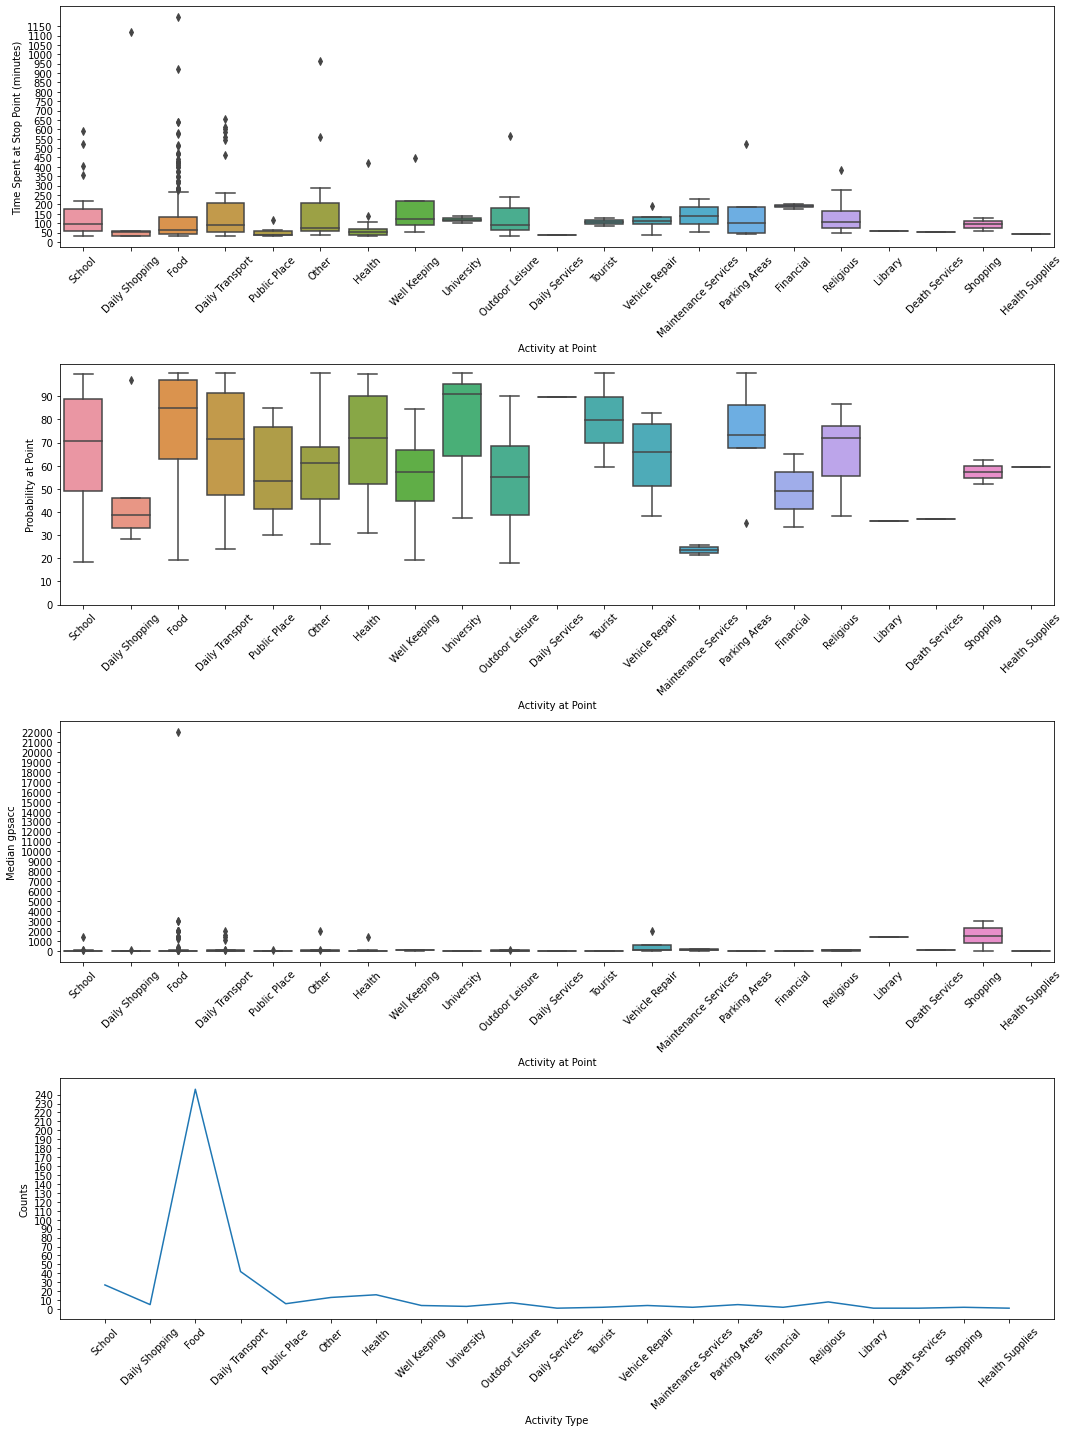

In [ ]:
fig,ax = plt.subplots(4,1,figsize = (15,20))
sns.boxplot(data = combined_df,x = 'Activity at Point',y = 'Time Spent at Stop Point (minutes)',ax = ax[0])
sns.boxplot(data = combined_df,x = 'Activity at Point',y = 'Probability at Point',ax = ax[1])
sns.boxplot(data = combined_df,x = 'Activity at Point',y = 'Median gpsacc',ax = ax[2])
sns.lineplot(data = counts_df,x = 'Activity Type',y = 'Counts',ax = ax[3])
ax[0].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[1].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[2].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[3].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[0].yaxis.set_ticks(np.arange(0,combined_df['Time Spent at Stop Point (minutes)'].max(),step = 50))
ax[1].yaxis.set_ticks(np.arange(0,100,step = 10))
ax[2].yaxis.set_ticks(np.arange(0,combined_df['Median gpsacc'].max(),step = 1000))
ax[3].yaxis.set_ticks(np.arange(0,counts_df['Counts'].max(),step = 10))
fig.tight_layout()

In [ ]:
from ast import literal_eval
test = poigdf.copy()
test['transit_station'] = np.nan
test['transit_station'] = test['POI Type'].apply(lambda x:True if 'transit_station' in literal_eval(x) else False)

In [ ]:
test = test.loc[test['transit_station'] == True]

In [ ]:
test

,Stop Point,UUID,POI Point,POI Name,POI Type,Time Spent at Stop Point,Stop Point Latitude,Stop Point Longitude,transit_station
24,POINT (114.12361 22.49032),111926,POINT (114.122947 22.490316),Ping Kong Road - Ping Kong,"['transit_station', 'point_of_interest', 'esta...",12479.0,22.490323,114.123607,True
161,POINT (114.21814 22.33500),111135,POINT (114.218016 22.334992),Choi Fai Estatae,"['transit_station', 'point_of_interest', 'esta...",33572.0,22.334997,114.218142,True
239,POINT (114.22638 22.32243),112114,POINT (114.225995 22.322333),高雷中學,"['transit_station', 'point_of_interest', 'esta...",2478.0,22.322428,114.226382,True
240,POINT (114.22638 22.32243),112114,POINT (114.2257465 22.322895),基督教聯合醫院,"['transit_station', 'point_of_interest', 'esta...",2478.0,22.322428,114.226382,True
241,POINT (114.22638 22.32243),112114,POINT (114.226059 22.322495),Ko Lui Secondary School,"['transit_station', 'point_of_interest', 'esta...",2478.0,22.322428,114.226382,True
...,...,...,...,...,...,...,...,...,...
7460,POINT (114.20640 22.34497),111566,POINT (114.20631 22.34544),Po Kong Village Road School Village; Po Kong V...,"['transit_station', 'point_of_interest', 'esta...",1968.0,22.344972,114.206395,True
7461,POINT (114.20640 22.34497),111566,POINT (114.206386 22.345586),Diamond Hill Crematorium,"['transit_station', 'point_of_interest', 'esta...",1968.0,22.344972,114.206395,True
7462,POINT (114.20640 22.34497),111566,POINT (114.20706 22.34481),Diamond Hill Crematorium; Po Kong Village Road,"['transit_station', 'point_of_interest', 'esta...",1968.0,22.344972,114.206395,True
7466,POINT (114.20640 22.34497),111566,POINT (114.207283 22.344631),Diamond Hill Crematorium,"['transit_station', 'point_of_interest', 'esta...",1968.0,22.344972,114.206395,True


In [ ]:
combined_df['Activity at Point'].unique()

array(['School', 'Daily Shopping', 'Food', 'Daily Transport',
       'Public Place', 'Other', 'Health', 'Well Keeping', 'University',
       'Outdoor Leisure', 'Daily Services', 'Tourist', 'Vehicle Repair',
       'Maintenance Services', 'Parking Areas', 'Financial', 'Religious',
       'Library', 'Death Services', 'Shopping', 'Health Supplies'],
      dtype=object)

In [ ]:
test2 = combined_df.loc[combined_df['Activity at Point'] == 'Daily Transport']

In [ ]:
test2.merge(test,on = ['Stop Point Latitude', 'Stop Point Longitude','UUID'],how = 'left').to_csv('DailyTransport.csv')

In [ ]:
combined_df_gps = combined_df.loc[combined_df['Median gpsacc'] < 100]
counts_df_gps = calculate_counts_for_each_activity(combined_df_gps)

In [ ]:
counts_df_gps

,Activity Type,Counts
0,School,26.0
1,Daily Shopping,5.0
2,Food,227.0
3,Daily Transport,37.0
4,Public Place,6.0
5,Other,12.0
6,Health,15.0
7,Well Keeping,2.0
8,University,3.0
9,Outdoor Leisure,6.0


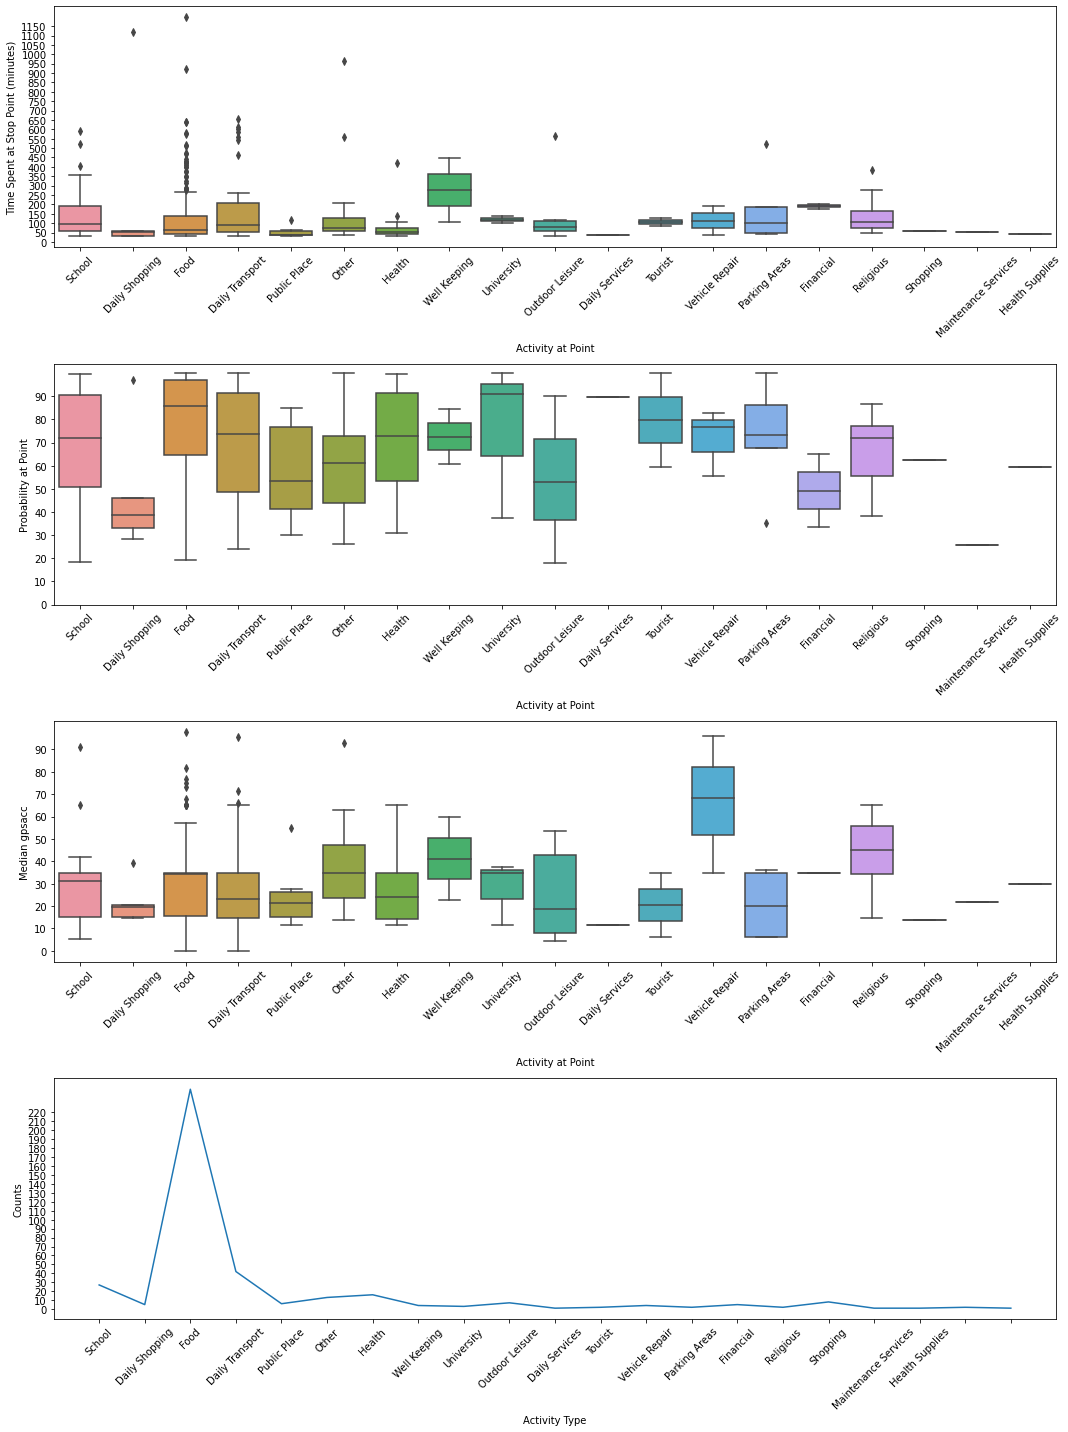

In [ ]:

fig,ax = plt.subplots(4,1,figsize = (15,20))
sns.boxplot(data = combined_df_gps,x = 'Activity at Point',y = 'Time Spent at Stop Point (minutes)',ax = ax[0])
sns.boxplot(data = combined_df_gps,x = 'Activity at Point',y = 'Probability at Point',ax = ax[1])
sns.boxplot(data = combined_df_gps,x = 'Activity at Point',y = 'Median gpsacc',ax = ax[2])
sns.lineplot(data = counts_df,x = 'Activity Type',y = 'Counts',ax = ax[3])
ax[0].set_xticklabels(rotation = 45,labels=combined_df_gps['Activity at Point'].unique().tolist())
ax[1].set_xticklabels(rotation = 45,labels=combined_df_gps['Activity at Point'].unique().tolist())
ax[2].set_xticklabels(rotation = 45,labels=combined_df_gps['Activity at Point'].unique().tolist())
ax[3].set_xticklabels(rotation = 45,labels=combined_df_gps['Activity at Point'].unique().tolist())
ax[0].yaxis.set_ticks(np.arange(0,combined_df_gps['Time Spent at Stop Point (minutes)'].max(),step = 50))
ax[1].yaxis.set_ticks(np.arange(0,100,step = 10))
ax[2].yaxis.set_ticks(np.arange(0,combined_df_gps['Median gpsacc'].max(),step = 10))
ax[3].yaxis.set_ticks(np.arange(0,counts_df_gps['Counts'].max(),step = 10))
fig.tight_layout()

In [ ]:
combined_df.loc[combined_df['Activity at Point'] == 'Food']['Time Spent at Stop Point (minutes)'].describe()

count     246.000000
mean      126.628997
std       150.995034
min        30.533333
25%        42.154167
50%        65.833333
75%       133.695833
max      1197.083333
Name: Time Spent at Stop Point (minutes), dtype: float64

Redrawing plots after removing the point causing the gpsacc to be more than 22,000

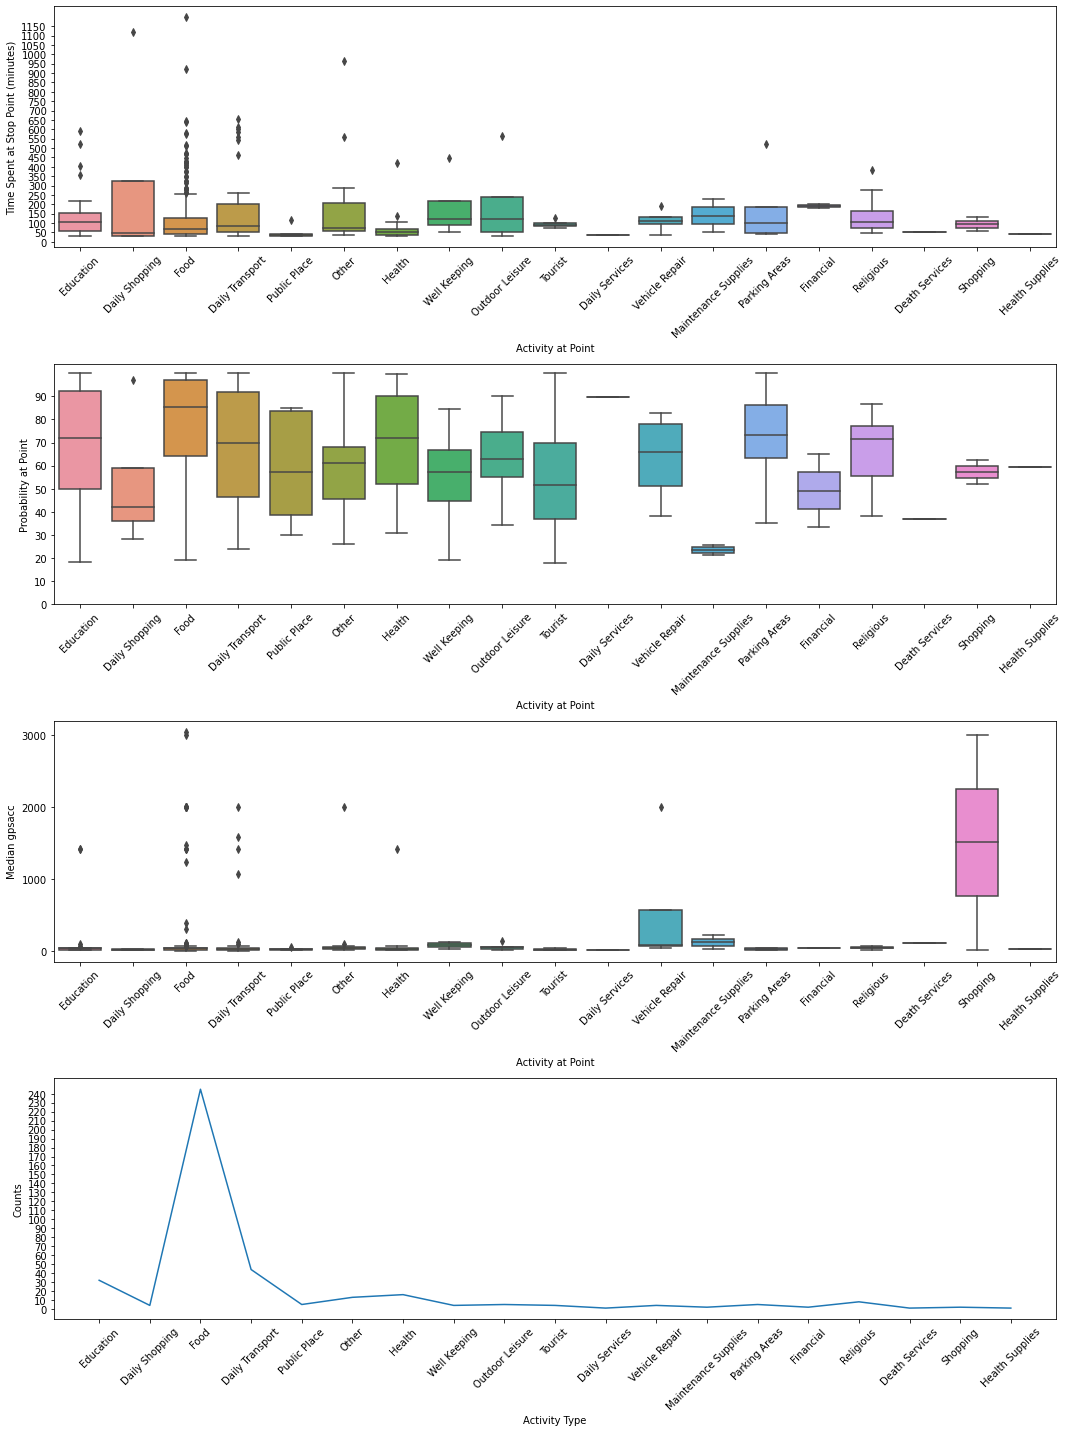

In [ ]:
combined_df = combined_df.loc[combined_df['Median gpsacc'] < 21000]
fig,ax = plt.subplots(4,1,figsize = (15,20))
sns.boxplot(data = combined_df,x = 'Activity at Point',y = 'Time Spent at Stop Point (minutes)',ax = ax[0])
sns.boxplot(data = combined_df,x = 'Activity at Point',y = 'Probability at Point',ax = ax[1])
sns.boxplot(data = combined_df,x = 'Activity at Point',y = 'Median gpsacc',ax = ax[2])
sns.lineplot(data = counts_df,x = 'Activity Type',y = 'Counts',ax = ax[3])
ax[0].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[1].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[2].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[3].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[0].yaxis.set_ticks(np.arange(0,combined_df['Time Spent at Stop Point (minutes)'].max(),step = 50))
ax[1].yaxis.set_ticks(np.arange(0,100,step = 10))
ax[2].yaxis.set_ticks(np.arange(0,combined_df['Median gpsacc'].max(),step = 1000))
ax[3].yaxis.set_ticks(np.arange(0,counts_df_gps['Counts'].max(),step = 10))
fig.tight_layout()

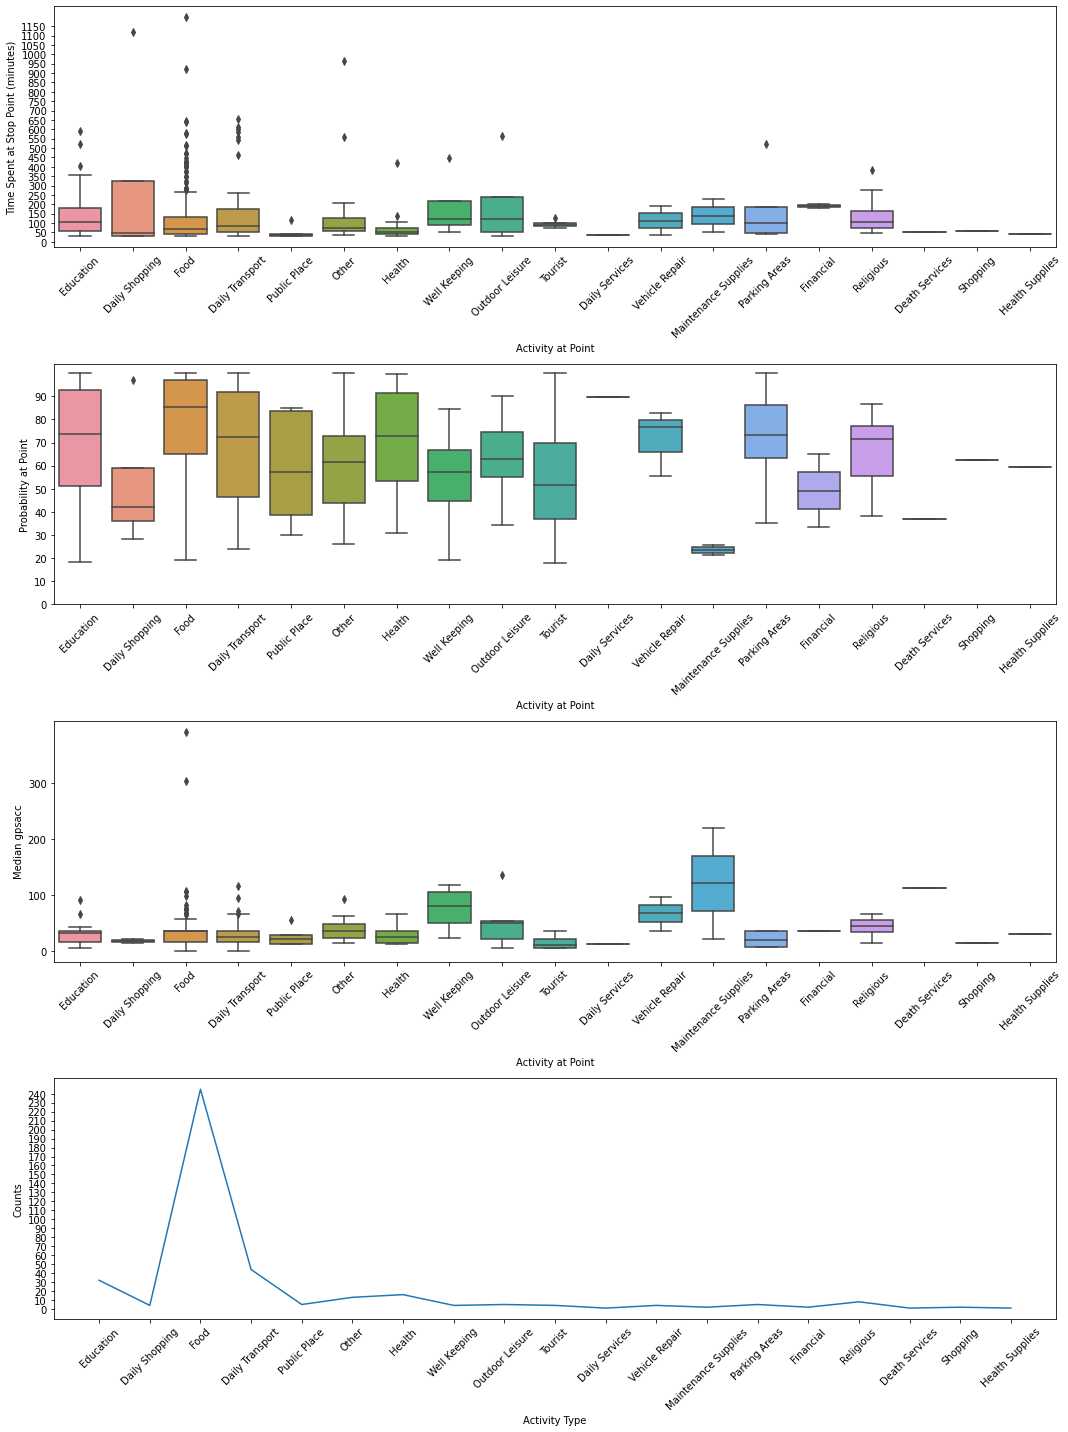

In [ ]:
combined_df_1000gpsacc = combined_df.loc[combined_df['Median gpsacc'] < 1000]
fig,ax = plt.subplots(4,1,figsize = (15,20))
sns.boxplot(data = combined_df_1000gpsacc,x = 'Activity at Point',y = 'Time Spent at Stop Point (minutes)',ax = ax[0])
sns.boxplot(data = combined_df_1000gpsacc,x = 'Activity at Point',y = 'Probability at Point',ax = ax[1])
sns.boxplot(data = combined_df_1000gpsacc,x = 'Activity at Point',y = 'Median gpsacc',ax = ax[2])
sns.lineplot(data = counts_df,x = 'Activity Type',y = 'Counts',ax = ax[3])
ax[0].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[1].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[2].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[3].set_xticklabels(rotation = 45,labels=activity_df['Activity at Point'].unique().tolist())
ax[0].yaxis.set_ticks(np.arange(0,combined_df_1000gpsacc['Time Spent at Stop Point (minutes)'].max(),step = 50))
ax[1].yaxis.set_ticks(np.arange(0,100,step = 10))
ax[2].yaxis.set_ticks(np.arange(0,combined_df_1000gpsacc['Median gpsacc'].max(),step = 100))
ax[3].yaxis.set_ticks(np.arange(0,counts_df['Counts'].max(),step = 10))
fig.tight_layout()

In [ ]:
counts_df

,Activity Type,Counts
0,Education,32.0
1,Daily Shopping,4.0
2,Food,245.0
3,Daily Transport,44.0
4,Public Place,5.0
5,Other,13.0
6,Health,16.0
7,Well Keeping,4.0
8,Outdoor Leisure,5.0
9,Tourist,4.0


In [ ]:
poigdf

,Stop Point,UUID,POI Point,POI Name,POI Type,Time Spent at Stop Point,Stop Point Latitude,Stop Point Longitude
0,POINT (114.19380 22.34506),111926,POINT (114.193536 22.3451875),TamJai SamGor MiXian,"['restaurant', 'food', 'point_of_interest', 'e...",16833.0,22.345057,114.193804
1,POINT (114.19380 22.34506),111926,POINT (114.1946307 22.3457345),Tung Yuen House,"['point_of_interest', 'establishment']",16833.0,22.345057,114.193804
2,POINT (114.19380 22.34506),111926,POINT (114.1936614 22.3448671),Maxim's MX,"['restaurant', 'food', 'point_of_interest', 'e...",16833.0,22.345057,114.193804
3,POINT (114.19380 22.34506),111926,POINT (114.1936343 22.3447961),順鑫腸粉佬,"['restaurant', 'food', 'point_of_interest', 'e...",16833.0,22.345057,114.193804
4,POINT (114.19380 22.34506),111926,POINT (114.1933114 22.3450458),Chuk Yuen Plaza,"['shopping_mall', 'point_of_interest', 'establ...",16833.0,22.345057,114.193804
...,...,...,...,...,...,...,...,...
7520,POINT (114.14136 22.37093),111566,POINT (114.140846 22.371575),Saint John the Apostle Chapel,"['church', 'place_of_worship', 'point_of_inter...",2127.0,22.370926,114.141365
7521,POINT (114.14136 22.37093),111566,POINT (114.1415615 22.3709132),kimura bakery,"['bakery', 'store', 'food', 'point_of_interest...",2127.0,22.370926,114.141365
7522,POINT (114.14136 22.37093),111566,POINT (114.141555 22.370816),波記,"['point_of_interest', 'establishment']",2127.0,22.370926,114.141365
7523,POINT (114.14136 22.37093),111566,POINT (114.141555 22.370816),安蔭眼鏡公司,"['point_of_interest', 'establishment']",2127.0,22.370926,114.141365


In [ ]:
def makeFoliumMap(trajectory):
    map = folium.Map([22.3193,114.1694],zoom_start=12)
    for x in trajectory.to_dict(orient = 'records'):
        long = x['geometry'].x
        lat = x['geometry'].y
        if x['Stop Or Moving'] == 'S':
            folium.CircleMarker(location = [lat,long],radius = 10,fill_color = 'red').add_to(map)
        else:
            folium.CircleMarker(location = [lat,long],radius = 10,fill_color = 'blue',fill_opacity = 0).add_to(map)
    return map

def plotTrajectoryWithStops(stop_time_ranges,trajectory,plot_map):
    trajectory['Stop Or Moving'] = ['M'] * trajectory.shape[0]
    for x in stop_time_ranges.to_dict(orient = 'records'):
        trajectory.loc[x['start_time']:x['end_time'],'Stop Or Moving'] = 'S'
    if plot_map is True:
        map = makeFoliumMap(trajectory)
        return trajectory,map
    else:
        return trajectory,None

In [ ]:
daily_trajectories = obtain_daily_trajectory(uuid_collection_obj.uuid_collection[111051].geodataframe_trajectory)
stop_points = uuid_collection_obj.uuid_collection[111051].mpd_stop_points['2023-04-03']
traj,map = plotTrajectoryWithStops(stop_points,daily_trajectories['2023-04-03'],True)

In [ ]:
daily_trajectories = obtain_daily_trajectory(uuid_collection_obj.uuid_collection[113305].geodataframe_trajectory)
stop_points = uuid_collection_obj.uuid_collection[113305].mpd_stop_points['2023-08-14']
traj,map = plotTrajectoryWithStops(stop_points,daily_trajectories['2023-08-14'],True)

In [ ]:
map